In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight

In [2]:
# configurations
source_path = "chest_xray"
data_dir = pathlib.Path(source_path)  
image_size = (224, 224) 
batch_size = 32
initial_epochs = 10                 
fine_tune_epochs = 15  

In [3]:
#get class names
class_names = sorted([p.name for p in data_dir.iterdir() if p.is_dir()])
print(class_names)

['test', 'train', 'val']


In [4]:
training_imgs = list(data_dir.glob('train/PNEUMONIA/*'))

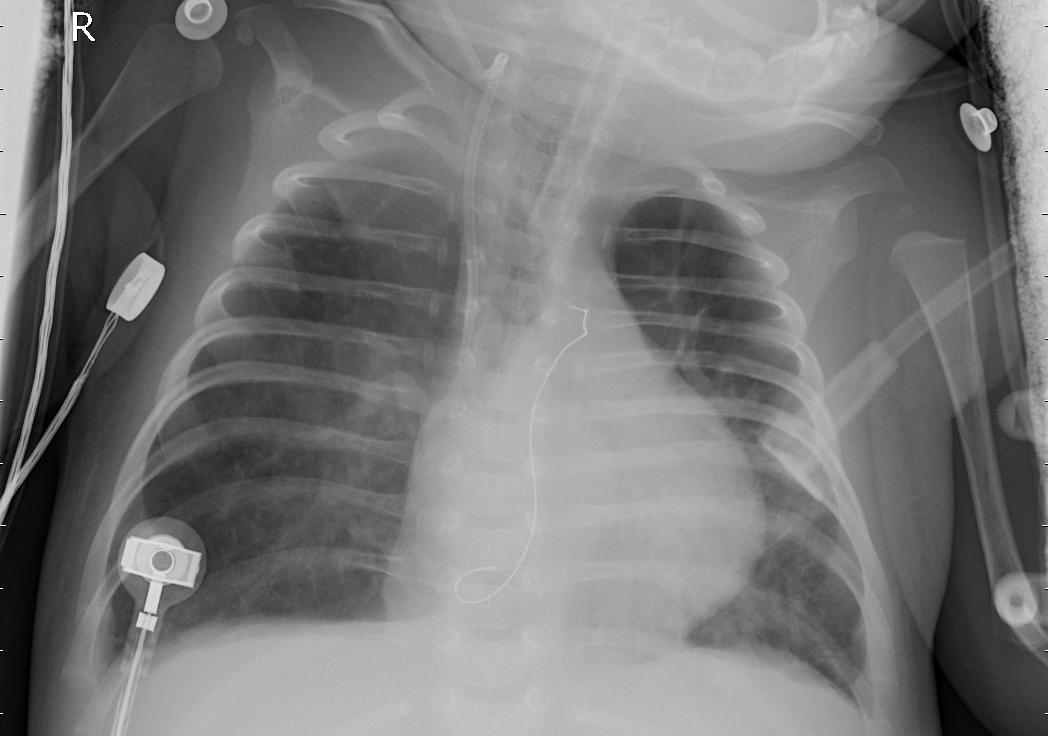

In [5]:
PIL.Image.open(str(training_imgs[0]))

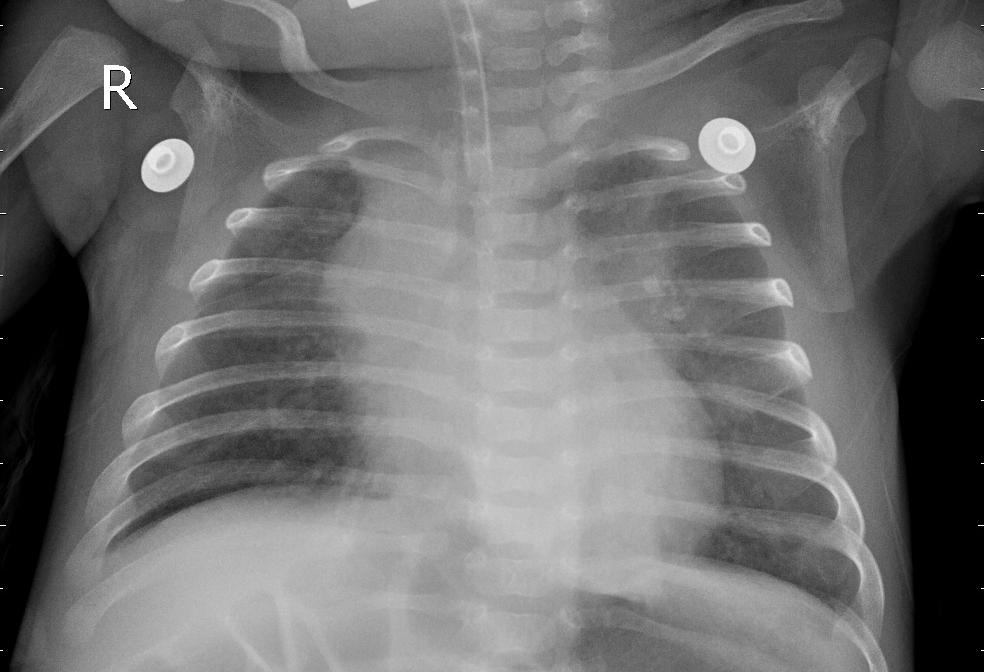

In [6]:
PIL.Image.open(str(training_imgs[1]))

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "chest_xray/train",
    seed = 123,
    image_size = image_size,
    batch_size=batch_size
)

Found 5216 files belonging to 2 classes.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "chest_xray/val",
    seed = 123,
    image_size = image_size,
    batch_size=batch_size
)

Found 16 files belonging to 2 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [10]:
labels_list = []
for _, labels in train_ds:
    labels_list.extend(labels.numpy())
class_weights = class_weight.compute_class_weight('balanced',
                                                   classes = np.unique(labels_list), 
                                                   y = labels_list)
class_weights = dict(enumerate(class_weights))

2025-05-22 15:38:27.896349: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-05-22 15:38:27.969264: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


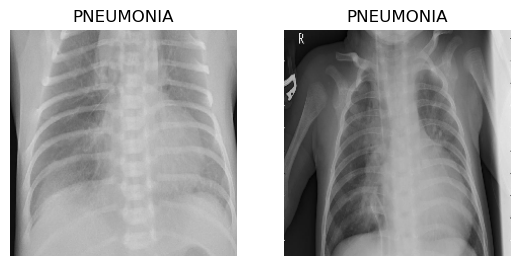

In [11]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(2):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

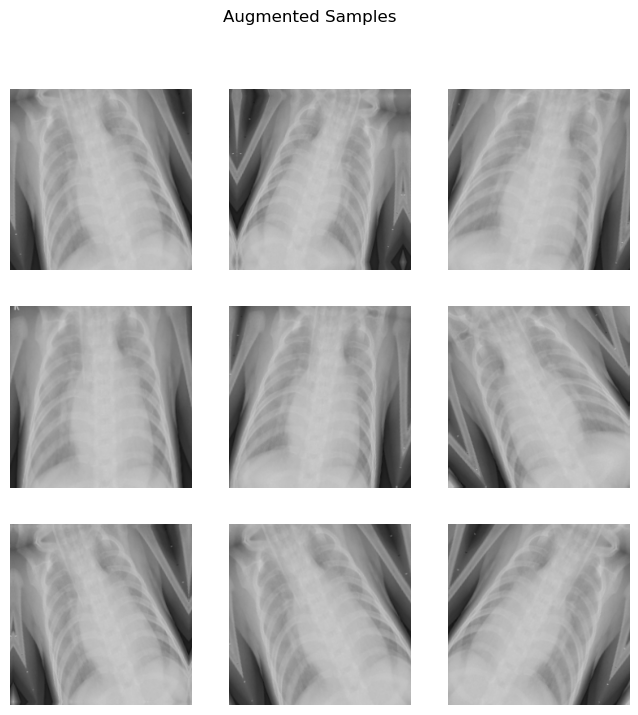

In [12]:
#augment images and verify not too extreme
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    #layers.RandomContrast(0.1),
], name='augmentation')

plt.figure(figsize=(8,8))
for images, _ in train_ds.take(1):
    first_img = images[0]
    for i in range(min(9, images.shape[0])):
        aug_img = data_augmentation(tf.expand_dims(first_img, 0))[0]
        ax = plt.subplot(3,3,i+1)
        plt.imshow(aug_img.numpy().astype("uint8"))
        plt.axis('off')
plt.suptitle('Augmented Samples')
plt.show()

In [13]:
#normalization of densenet
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [14]:
"""
build using densenet (because it works better with medical images) and freeze so it locks 
the backbone weights during initial training and dont delete pretrained features
"""
base_model = tf.keras.applications.DenseNet121(
    input_shape=image_size + (3,), include_top=False, weights = 'imagenet'
)
base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
inputs = layers.Input(shape = image_size+(3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(2, activation='softmax')(x) 
model = models.Model(inputs,outputs)

In [16]:
"""
adam to transfer learning, sparce cce since labels are ints and not one hot encoded
modelcheckpoint savs best head-only model, early stopping stops if val loss stalls to prevent 
overfitting
"""
early_stop1 = callbacks.EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
cp1=callbacks.ModelCheckpoint('mnetv3l_initial.keras', save_best_only=True, monitor='val_accuracy')
model.compile(
    optimizer = optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [17]:
#train only head layers for 10 epochs
history_initial = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = initial_epochs,
    callbacks = [cp1, early_stop1],
    class_weight=class_weights
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 704ms/step - accuracy: 0.7053 - loss: 0.5713 - val_accuracy: 0.9375 - val_loss: 0.2759
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 753ms/step - accuracy: 0.9008 - loss: 0.2479 - val_accuracy: 0.9375 - val_loss: 0.1811
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 773ms/step - accuracy: 0.9207 - loss: 0.2047 - val_accuracy: 0.9375 - val_loss: 0.1575
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 755ms/step - accuracy: 0.9199 - loss: 0.1993 - val_accuracy: 1.0000 - val_loss: 0.1273
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 763ms/step - accuracy: 0.9256 - loss: 0.1831 - val_accuracy: 0.9375 - val_loss: 0.1240
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 768ms/step - accuracy: 0.9264 - loss: 0.1717 - val_accuracy: 0.9375 - val_loss: 0.1319
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 791ms/step - accuracy: 0.9368 - loss: 0.1624 - val_accuracy: 1.0000 - val_loss: 0.1107
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 759ms/step - accuracy: 0.9410 -

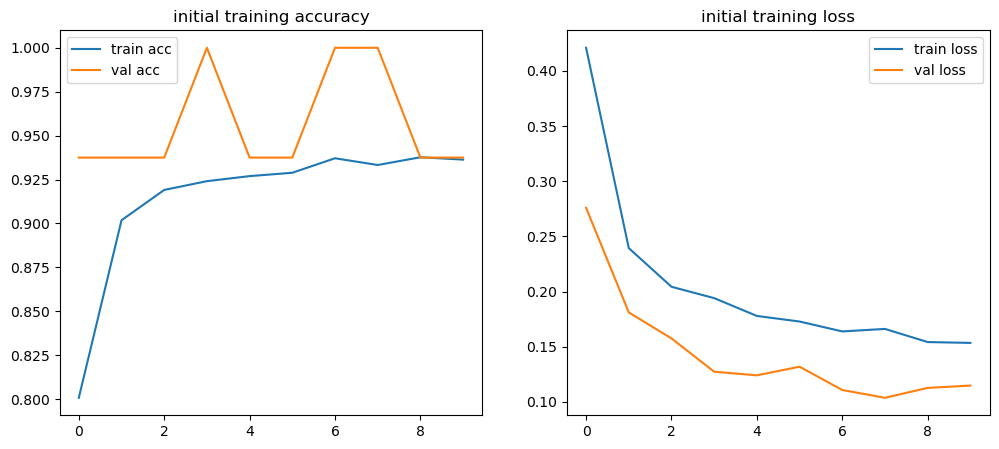

In [18]:
# visualize training vs val accuracy/loss
acc = history_initial.history['accuracy']
val_acc = history_initial.history['val_accuracy']
loss = history_initial.history['loss']
val_loss = history_initial.history['val_loss']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.legend(); plt.title('initial training accuracy')
plt.subplot(1, 2, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend(); plt.title('initial training loss')
plt.show()

In [19]:
#unfreeze backbone so weights can adapt to xray imgs
#freeze first 100 layers to keep low-level filters stable
early_stop2 = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

cp2 = callbacks.ModelCheckpoint(
    'mnetv3l_finetuned.keras', 
    save_best_only=True, 
    monitor='val_accuracy'
)

In [20]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=initial_epochs,
    callbacks=[cp2, early_stop2],
    class_weight = class_weights
)

Epoch 11/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.8571 - loss: 1.1134 - val_accuracy: 0.9375 - val_loss: 0.1064
Epoch 12/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9400 - loss: 0.1728 - val_accuracy: 1.0000 - val_loss: 0.0422
Epoch 13/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9438 - loss: 0.1395 - val_accuracy: 1.0000 - val_loss: 0.0375
Epoch 14/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9564 - loss: 0.1125 - val_accuracy: 1.0000 - val_loss: 0.0290
Epoch 15/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9618 - loss: 0.0980 - val_accuracy: 1.0000 - val_loss: 0.0311
Epoch 16/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9631 - loss: 0.0976 - val_accuracy: 1.0000 - val_loss: 0.0335
Epoch 17/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9655 - loss: 0.0822 - val_accuracy: 1.0000 - val_loss: 0.0429
Epoch 18/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9673 - loss: 0.0801 - 

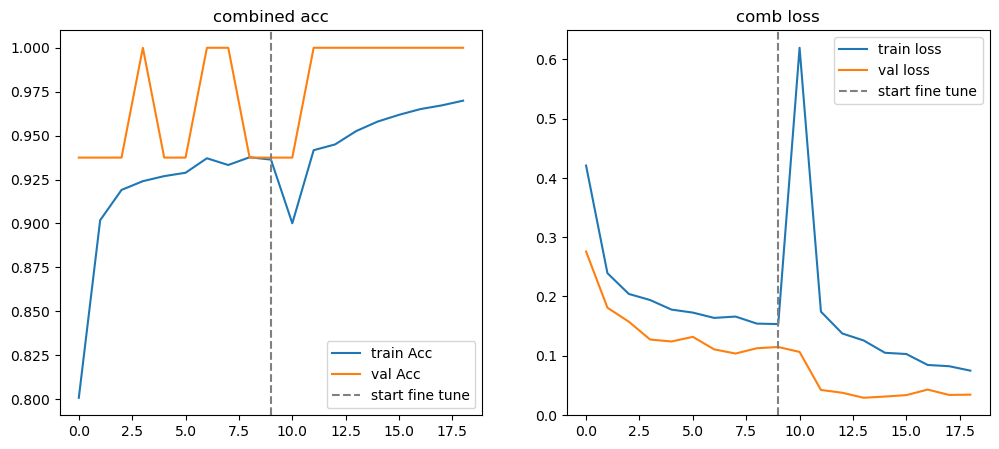

In [21]:
# visualize how much gain fine tuning provides 
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train Acc')
plt.plot(val_acc, label='val Acc')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='start fine tune')
plt.legend(); plt.title('combined acc')
plt.subplot(1, 2, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='start fine tune')
plt.legend(); plt.title('comb loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 1.0000 - loss: 0.0290
final val acc: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


2025-05-22 16:28:44.181020: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


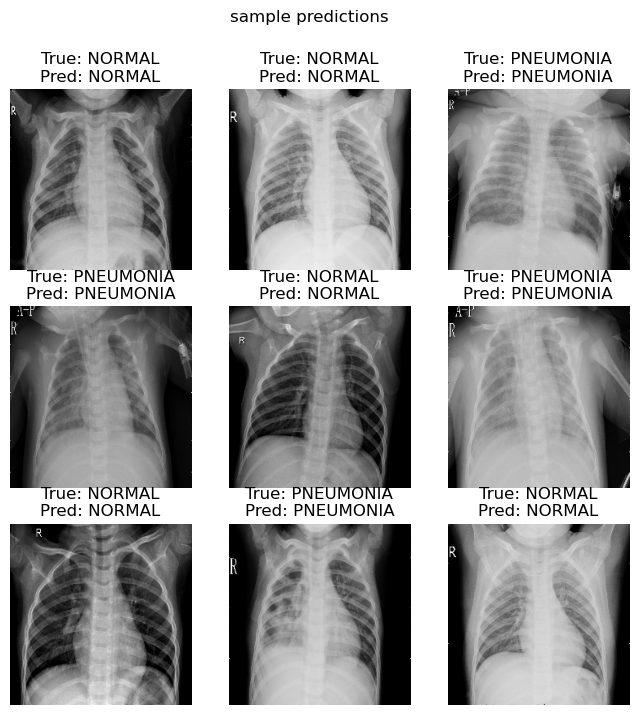

In [22]:
#get val loss/accuracy
loss, acc = model.evaluate(val_ds)
print(f"final val acc: {acc:.2%}")

plt.figure(figsize=(8, 8))
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        title = f"True: {class_names[int(labels[i])]}\nPred: {class_names[preds_labels[i]]}"
        plt.title(title)
        plt.axis('off')
plt.suptitle('sample predictions')
plt.show()

# save final model
model.save("final_model.keras")

In [23]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "chest_xray/test",
    seed = 123,
    image_size = image_size,
    batch_size=batch_size
)

loss, acc = model.evaluate(test_ds)
print(f"final test acc: {acc:.2%}")

Found 624 files belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 437ms/step - accuracy: 0.9151 - loss: 0.2547
final test acc: 90.71%
